In [174]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_inputs = 2
num_neurons = 3

In [4]:
x0 = tf.placeholder(tf.float32, [None, num_inputs])
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [5]:
Wx = tf.random_normal(shape=[num_inputs, num_neurons])
Wy = tf.random_normal(shape=[num_neurons, num_neurons])
b = tf.zeros([1, num_neurons])

In [6]:
# graphs
y0 = tf.tanh(tf.matmul(x0, Wx) + b)
# feedback + present
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx) + b)

In [7]:
# intialize variables
init = tf.global_variables_initializer()

In [8]:
# create data
# time stamp at t = 0
x0_batch = np.array([ [0, 1], [2, 3], [4, 5] ])
# time stamp at t = t + 1 = 1
x1_batch = np.array([ [100, 101], [102, 103], [104, 105] ])

In [9]:
with tf.Session() as sess:
    sess.run(init)
    
    y0_output_vals, y1_output_vals = sess.run([y0, y1], 
                    feed_dict = {x0:x0_batch, x1:x1_batch})

In [10]:
y0_output_vals

array([[ 0.46511364, -0.921773  ,  0.9284943 ],
       [ 0.96557266, -0.9307549 ,  0.9783266 ],
       [ 0.9983207 , -0.93873835,  0.993547  ]], dtype=float32)

In [11]:
y1_output_vals

array([[ 1.        , -0.99936646,  1.        ],
       [ 1.        , -0.9977223 ,  1.        ],
       [ 1.        , -0.99780226,  1.        ]], dtype=float32)

## Vanishing Gradients

While backpropagating, in deeper networks, gradients get smaller and at some point, they stop changing significantly.

GRU and LSTM can be used to fix them (in RNN)

**Depends on activation function choice.**

Like **sigmoid:** $$\sigma(z) = \cfrac{1}{1 + e^{-z}}$$

It saturates both <strong>positive and negative</strong> values.

**Solution:**

Use **ReLU** (doesn't saturate <strong>positive</strong> values.) Problem: for -ve numbers, always 0.

**Solution:**

Use **Leaky ReLU.**

Others: **ELU** (Exponential Linear Unit)

**Another solution: Use Batch Normalization, Gradient Clipping (cut off gradients to be b/w -1 and 1  : example)**

## Introduction to RNN using TF API

**Problem:** Time series.
($sin(t)$, t = time)

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        # creates data
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (self.xmax - self.xmin)/(self.num_points)
        self.x_data = np.linspace(self.xmin, self.xmax, self.num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # grab random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        # convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - \
                                (steps * self.resolution))
        # create batch series : x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * \
        self.resolution
        # create y data for each x axis point
        y_batch = np.sin(batch_ts)
        # formatting for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), \
        y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            # returns at t = t and t = t + 1
            return y_batch[:, :-1].reshape(-1, steps, 1), \
        y_batch[:, 1:].reshape(-1, steps, 1)

In [18]:

ts_data = TimeSeriesData(250, 0, 10)

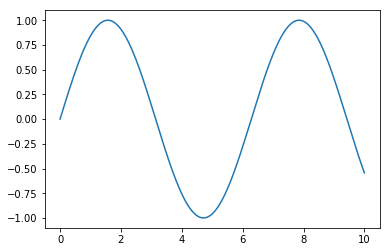

In [20]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [21]:
num_timesteps = 30 # number of steps in each batch

In [40]:
def generateNextBatch(num_timesteps):
    y1, y2, ts = ts_data.next_batch(1, num_timesteps, True)
    return y1, y2, ts

In [28]:
ts.shape
# needs to be flattened

(1, 30, 1)

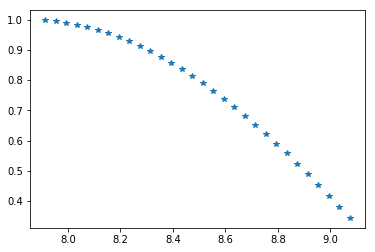

In [31]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

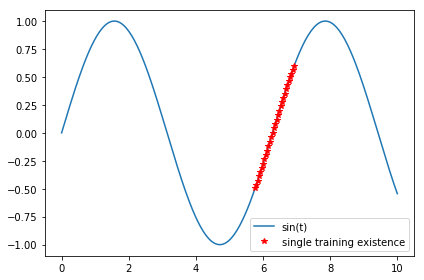

In [42]:
y1, y2, ts = generateNextBatch(30)
plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', c = 'r', label='single training existence')
plt.legend()
plt.tight_layout()

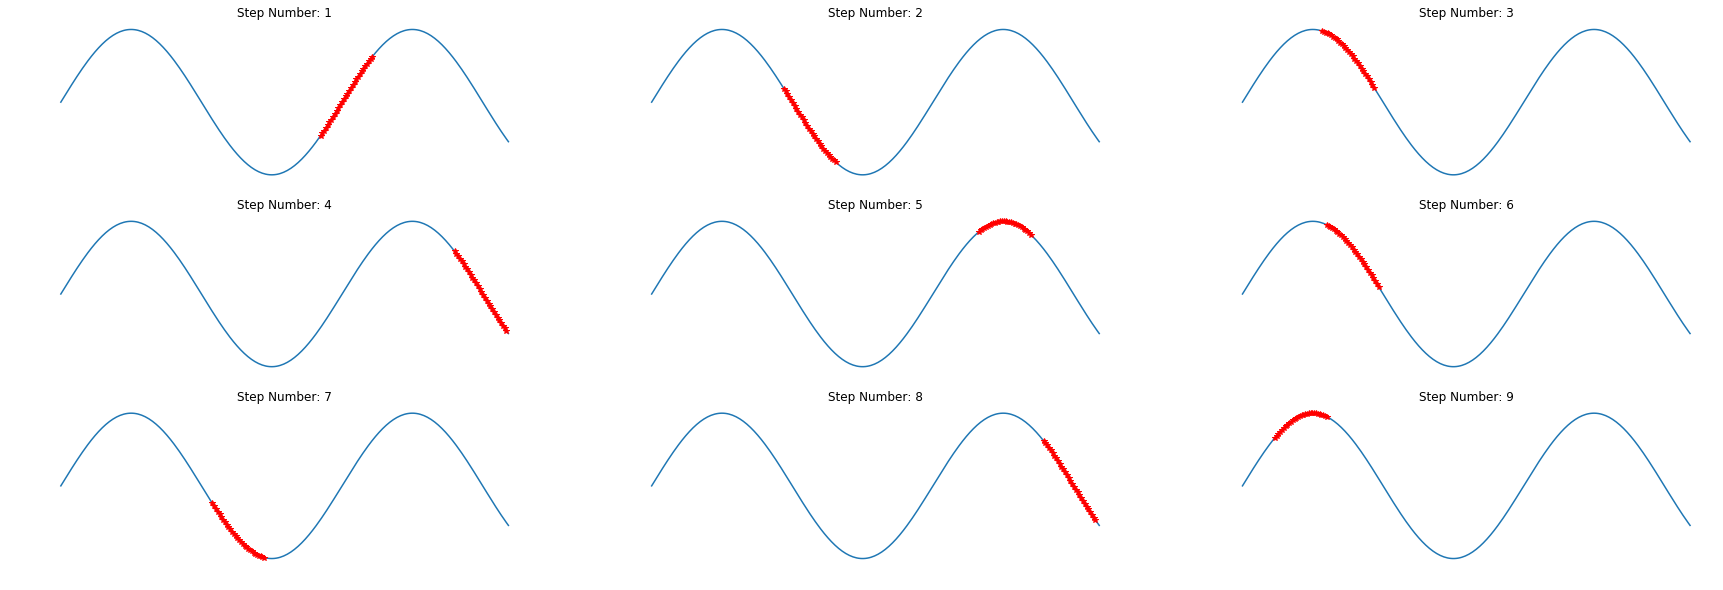

In [76]:
import math

plt.figure(figsize=[30,10]) 
num_cols = 3
num_images = 9
num_rows = math.ceil(num_images / num_cols)

for i in range(0, num_images):
    plt.subplot(num_rows, num_cols, i+1) 
    plt.axis('off')
    y1, y2, ts = generateNextBatch(30)
    plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
    plt.plot(ts.flatten()[1:], y2.flatten(), '*', c = 'r', label='single training existence')
    plt.title("Step Number: " + str(i + 1))

In [56]:
train_instance = np.linspace(5, 5 + ts_data.resolution * \
                    (num_timesteps + 1), num_timesteps + 1)

In [57]:
train_instance

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

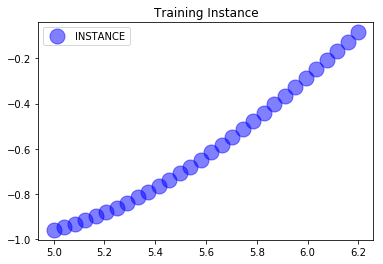

In [71]:
plt.title('Training Instance')

plt.plot(train_instance[:-1], ts_data.ret_true(train_instance[:-1]),
        'bo', markerSize=15, alpha=0.5, label='INSTANCE')

plt.legend()

We want to predict <strong>one time step</strong> ahead of it. \[Goal\]

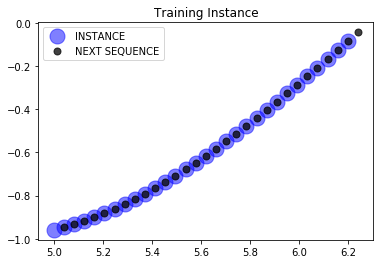

In [74]:
plt.title('Training Instance')

plt.plot(train_instance[:-1], ts_data.ret_true(train_instance[:-1]),
        'bo', markerSize=15, alpha=0.5, label='INSTANCE')
# doing for next time step (1: )
plt.plot(train_instance[1:], ts_data.ret_true(train_instance[1:]), 
        'ko', markerSize=7, alpha=0.75, label='NEXT SEQUENCE')

plt.legend()

<strong>Creating Model using Tensorflow</strong>

In [175]:
# usually necessary when a graph has already been created
# not needed here but worth it.
tf.reset_default_graph()

In [176]:
num_inputs = 1

In [177]:
num_neurons = 100 # number of neurons in a layer

In [178]:
num_outputs = 1 

In [196]:
lr = 0.001 # learning rate 
batch_size = 1
num_train_iterations = 2000 # 2000 steps

In [180]:
X = tf.placeholder(dtype=tf.float32, shape=[None, num_timesteps, \
                                            num_inputs])

In [181]:
Y = tf.placeholder(dtype=tf.float32, shape=[None, num_timesteps, \
                                            num_outputs])

In [89]:
# Recurrent Neural Network Cell Layer

In [182]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,
                                  activation=tf.nn.relu)
# output projection wrapper
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

In [183]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [184]:
# MSE
loss = tf.reduce_mean(tf.square(outputs - Y))

In [185]:
# optimizer - adam
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# optimizer minimzes the loss calculated above
train = optimizer.minimize(loss)

# initialize all variables
init = tf.global_variables_initializer()

In [97]:
# if using gpu
# uncomment the following line
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)

In [186]:
saver = tf.train.Saver() # saves model

In [197]:
with tf.Session() as sess:
    sess.run(init) 
    
    for iteration in range(num_train_iterations):
        X_batch, Y_batch = ts_data.next_batch(batch_size, num_timesteps)
        
        sess.run(train, feed_dict = {X:X_batch, Y:Y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, Y:Y_batch})
            print(iteration, "\tMSE", mse)
    
    saver.save(sess, "./rnn_time_series_codealong")

0 	MSE 0.54810894
100 	MSE 0.20570844
200 	MSE 0.0068678525
300 	MSE 0.003448643
400 	MSE 0.008003245
500 	MSE 0.0062846127
600 	MSE 6.705546e-05
700 	MSE 0.016843755
800 	MSE 0.00018747394
900 	MSE 0.0028962297
1000 	MSE 0.0023182756
1100 	MSE 0.0018538045
1200 	MSE 0.00010784715
1300 	MSE 0.0142185
1400 	MSE 0.0135010965
1500 	MSE 0.0065394198
1600 	MSE 0.008510323
1700 	MSE 0.001088756
1800 	MSE 0.01031712
1900 	MSE 0.0007852756


In [198]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_codealong")
    X_new = np.sin(np.array(train_instance[:-1].reshape(-1,
                        num_timesteps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong


<strong>Testing Model</strong>

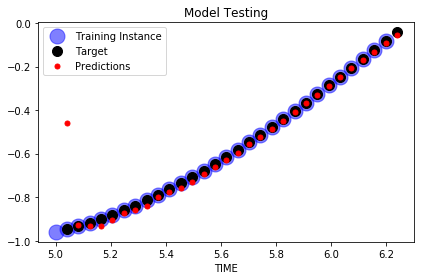

In [199]:
plt.title("Model Testing")

# training instance
plt.plot(train_instance[:-1], np.sin(train_instance[:-1]),
        "bo", markerSize=15, alpha=0.5, label="Training Instance")
# ground truth values (np.sin(training instance))
plt.plot(train_instance[1:], np.sin(train_instance[1:]),
        "ko", markerSize=10, label="Target")
# models prediction
plt.plot(train_instance[1:], y_pred[0,:,0], 'r.', 
        markerSize=10, label='Predictions')

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

In [190]:
def testing_model(steps):
    batch_size = 1
    with tf.Session() as sess:
        sess.run(init) 

        for iteration in range(steps):
            X_batch, Y_batch = ts_data.next_batch(batch_size, num_timesteps)

            sess.run(train, feed_dict = {X:X_batch, Y:Y_batch})

            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X:X_batch, Y:Y_batch})
                # print(iteration, "\tMSE", mse)

        saver.save(sess, "./rnn_time_series_codealong")
    
    with tf.Session() as sess:
        saver.restore(sess, "./rnn_time_series_codealong")
        X_new = np.sin(np.array(train_instance[:-1].reshape(-1,
                            num_timesteps, num_inputs)))
        y_pred = sess.run(outputs, feed_dict={X:X_new})
    
#     plt.title("Model Testing")
    
    return y_pred

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
100


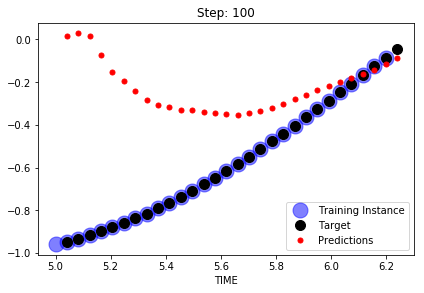

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
200


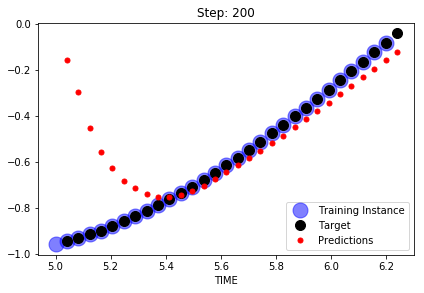

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
300


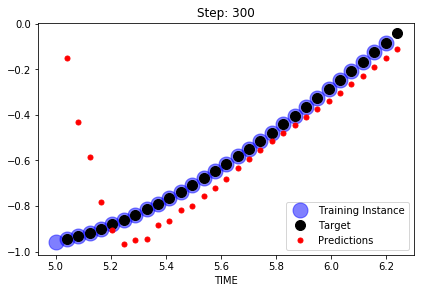

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
400


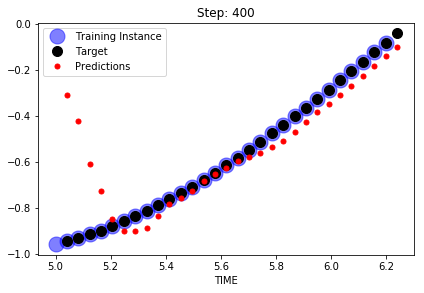

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
500


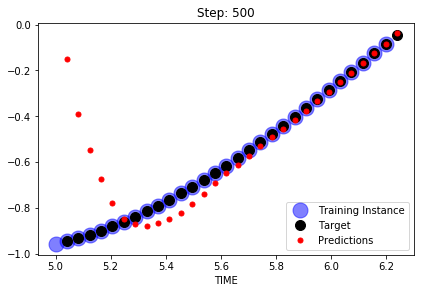

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
600


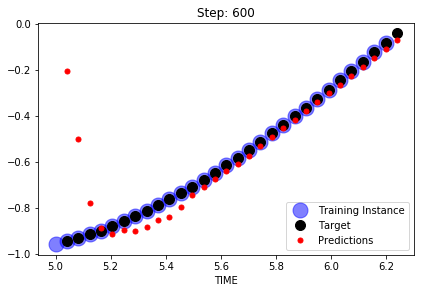

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
700


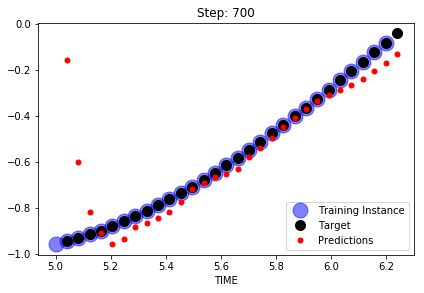

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
800


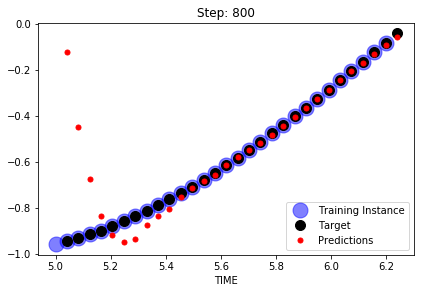

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
900


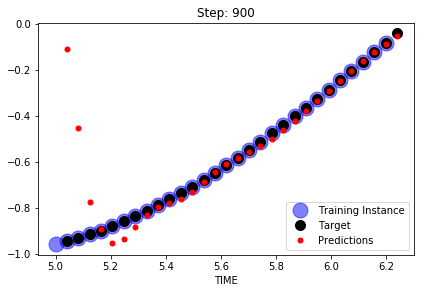

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1000


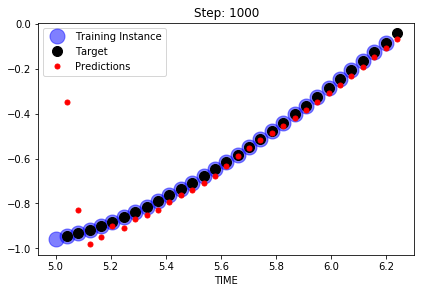

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1100


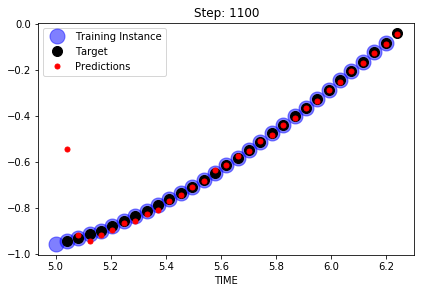

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1200


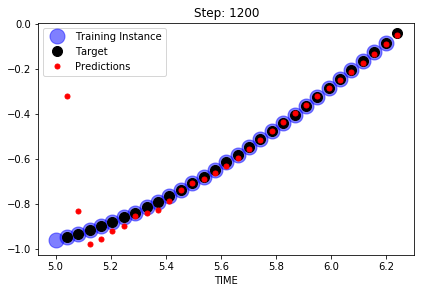

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1300


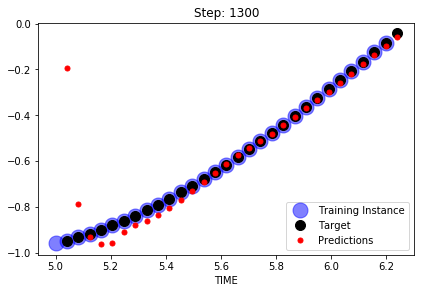

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1400


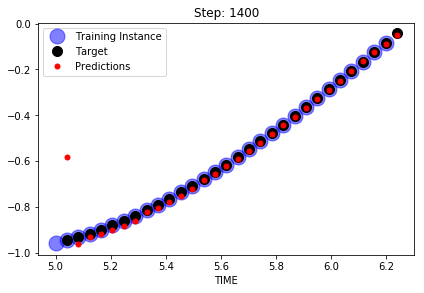

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1500


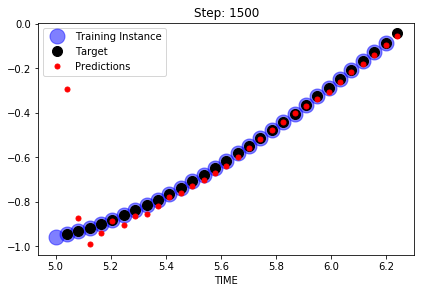

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1600


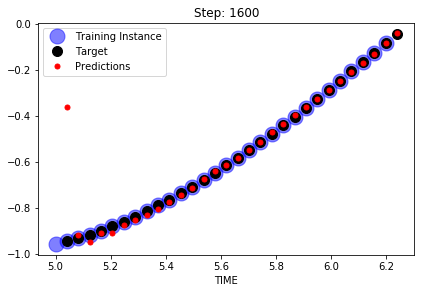

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1700


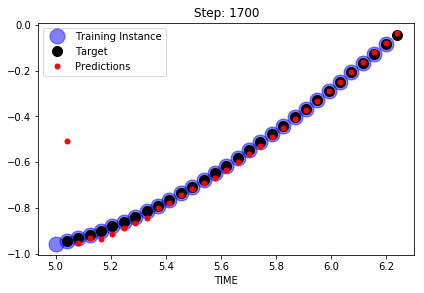

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1800


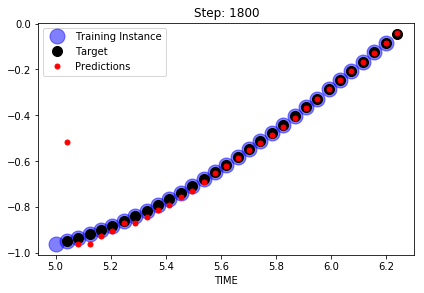

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
1900


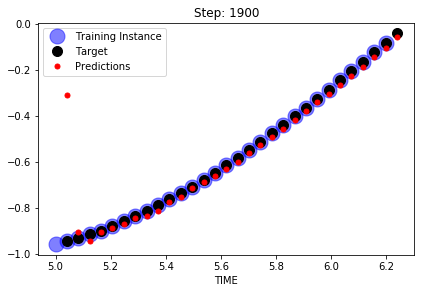

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong
2000


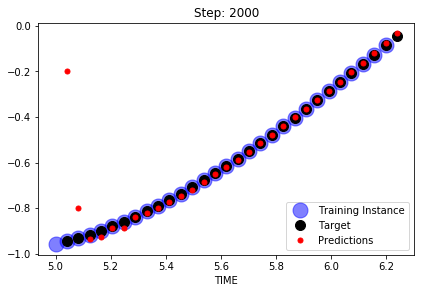

In [195]:
# plt.figure(figsize=[100, 30]) 

num_cols = 1
num_images = 9
num_rows = math.ceil(num_images / num_cols)

step = 100
i = 0
while(step <= 2000):
    # plt.subplot(num_rows, num_cols, i+1)
    
    y_pred = testing_model(step)
    
#     print(y_pred.shape)
    print(step)
    # y1, y2, ts = generateNextBatch(30)
    plt.plot(train_instance[:-1], np.sin(train_instance[:-1]),
        "bo", markerSize=15, alpha=0.5, label="Training Instance")
    # ground truth values (np.sin(training instance))
    plt.plot(train_instance[1:], np.sin(train_instance[1:]),
            "ko", markerSize=10, label="Target")
    # models prediction
    plt.plot(train_instance[1:], y_pred[0,:,0], 'r.', 
            markerSize=10, label='Predictions')

    plt.xlabel("TIME")
    plt.legend()
    plt.tight_layout()
    plt.title("Step: " + str(step))
    plt.show()
    step += 100
    i += 1
# training instance
    